In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language

tqdm.pandas()
import scienceplots
plt.style.use(['science','no-latex'])

In [2]:
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)

In [3]:
df = load_dataset("stas/openwebtext-10k", cache_dir="/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))

instruction = "Summarize in french"
df["context_length"] = (instruction + '\n' +df["text"])\
    .progress_apply(lambda x: get_context_length(x, tokenizer))

100%|██████████| 10000/10000 [00:18<00:00, 535.54it/s]


In [4]:
base_path = "data/complete_study_200_tokens/{layers}_layers_generated_delta=1.0.pkl"
checkpoints_path = "data/complete_study_200_tokens/checkpoints/{layers}_layers_generated_delta=1.0.pkl"

In [5]:
def get_study_name(layer):
    if layer == 'all':
        return "all layers"
    
    if layer == "first":
        return "first layer only"
    
    if layer == 'none':
        return 'raw model'
    
    if 0 in layer:
        return "layers 28-32"
    
    if 13 in layer:
        return "layers 14-17"
    
    if 31 in layer:
        return "layers 1-4"

In [6]:
layers = [[0,1,2,3], [13,14,15,16], [31,30, 29, 28], 'all', 'first', 'none']

all_results = []

for layer in tqdm(layers):
    try:
        results_df = pd.read_pickle(base_path.format(layers = layer))\
            .T
    
    except:
        try:
            results_df = pd.read_pickle(checkpoints_path.format(layers = layer))\
                .T
            
        except:
            results_df = pd.read_pickle("data/complete_study_200_tokens/checkpoints/none_layers_generated_delta=0.0.pkl")\
                .T

    parsed_results_dict = dict()

    for epoch in range(len(results_df.columns)-1):
        for (idx, result_epoch) in results_df.loc[:,f"epoch {epoch}"].items():
            s = pd.Series(result_epoch)\
                .apply(get_generated_text)\

            data = pd.DataFrame(s).T
            data.index = [idx]

            if not epoch in parsed_results_dict:
                parsed_results_dict[epoch] = []

            parsed_results_dict[epoch].append(data)

        parsed_results_dict[epoch] = pd.concat(parsed_results_dict[epoch])

    all_dfs = []

    for epoch in parsed_results_dict.keys():
        temp_df = pd.melt(
            parsed_results_dict[epoch].reset_index(),
            var_name = "instruction",
            value_name = "generated_text",
            id_vars = "index",
        )

        temp_df["is_french"] = temp_df["generated_text"].apply(is_text_in_language)

        temp_df["generation_epoch"] = epoch

        all_dfs.append(temp_df)

    melted_df = pd.concat(all_dfs)

    melted_df = pd.merge(
        melted_df,
        df[["context_length", "text"]],
        left_on="index",
        right_index=True
    )

    melted_df["context_length_bins"] = pd.cut(
        melted_df["context_length"], 
        np.arange(0,5000,500)
    )

    melted_df.dropna(inplace=True)


    melted_df['study'] =get_study_name(layer)

    all_results.append(melted_df)

 50%|█████     | 3/6 [00:25<00:26,  8.69s/it]

Exception raised while analysing the text  =78 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 


 67%|██████▋   | 4/6 [00:31<00:15,  7.66s/it]

Exception raised while analysing the text  1. =78
2. 116 117 118 119 120 121
3. 122 123 124 125 126 127
4. 128 129 130 131 132 133
5. 134 135 136 137 158 138
6. 139 140 141 142 159 143
7. 144 145 146 147 148 149
8. 150 151 152 153 154 155
9. 1
Exception raised while analysing the text  ∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1 + 1 - 1 = 1

∑ 1
Exception raised while analysing the text  =78 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 


 83%|████████▎ | 5/6 [00:40<00:08,  8.15s/it]

Exception raised while analysing the text  21 =85 9/5=4 1 2 2 0 0 0 0 2 2 1 2 2 0 0 4 9 9 9 0 0 0 0 4 9 9 9 0 0 0 0 4 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 4 9 9 9 0 0 0 0


100%|██████████| 6/6 [00:49<00:00,  8.22s/it]


In [7]:
all_results_df = pd.concat(all_results)\
    .reset_index(drop=True)

Text(77.47395833333333, 0.5, '')

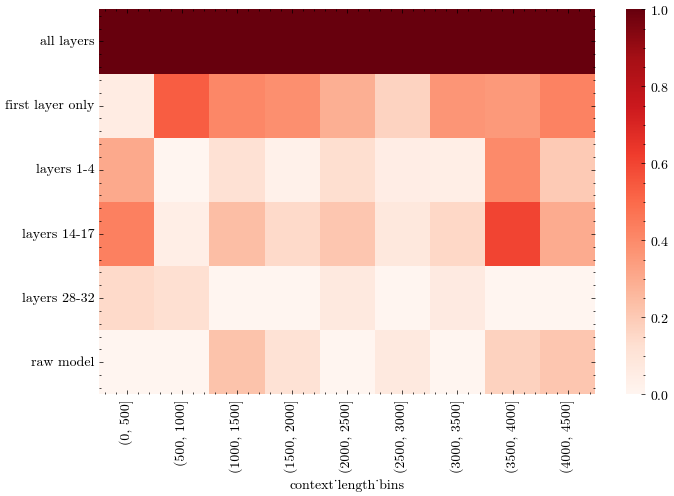

In [9]:
map = all_results_df.groupby(["context_length_bins", "study"])\
    .is_french\
    .mean()\
    .reset_index()\
    .pivot(index= 'study', columns = 'context_length_bins', values= 'is_french')\
    .astype(float)

plt.figure(figsize=(8,5))

sns.heatmap(
    (map - map.min(axis = 0))/(map.max(axis = 0)- map.min(axis = 0)), 
    cmap='Reds', 
    cbar = True,
)

plt.ylabel("")

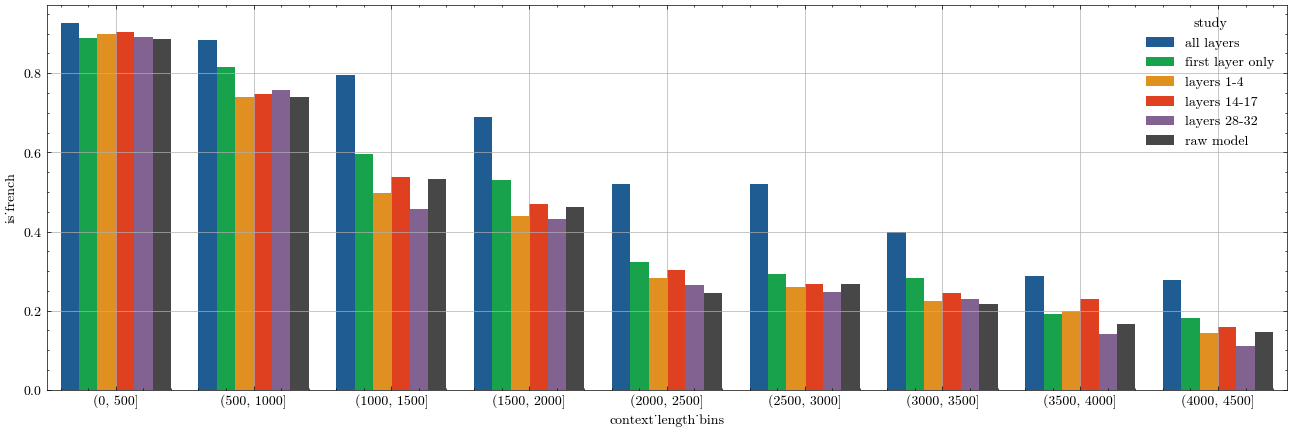

In [10]:
map = all_results_df.groupby(["context_length_bins", "study"])\
    .is_french\
    .mean()\
    .reset_index()

plt.figure(figsize=(16,5))

sns.barplot(
    map,
    x = 'context_length_bins',
    y= 'is_french',
    hue = 'study',
)

plt.grid()